Pobierz dane

In [84]:
import os
import wfdb

# Ścieżka do katalogu z bazą
data_dir = '../data/raw/afdb'

# Sprawdź, czy baza danych jest już pobrana
if not os.path.exists(data_dir) or len(os.listdir(data_dir)) == 0:
    print("Baza danych nie jest pobrana. Pobieranie...")
    wfdb.dl_database('afdb', dl_dir=data_dir)
    print("Baza danych została pobrana.")
else:
    print("Baza danych już istnieje w podanej lokalizacji.")

Baza danych nie jest pobrana. Pobieranie...
Generating record list for: 00735
Generating record list for: 03665
Generating record list for: 04015
Generating record list for: 04043
Generating record list for: 04048
Generating record list for: 04126
Generating record list for: 04746
Generating record list for: 04908
Generating record list for: 04936
Generating record list for: 05091
Generating record list for: 05121
Generating record list for: 05261
Generating record list for: 06426
Generating record list for: 06453
Generating record list for: 06995
Generating record list for: 07162
Generating record list for: 07859
Generating record list for: 07879
Generating record list for: 07910
Generating record list for: 08215
Generating record list for: 08219
Generating record list for: 08378
Generating record list for: 08405
Generating record list for: 08434
Generating record list for: 08455
Generating list of all files for: 00735
Generating list of all files for: 03665
Generating list of all fil

Wyświelt próbkę

Informacje o sygnale:
Częstotliwość próbkowania: 250 Hz
Czas trwania sygnału: 36823.04 s
Liczba kanałów: 2


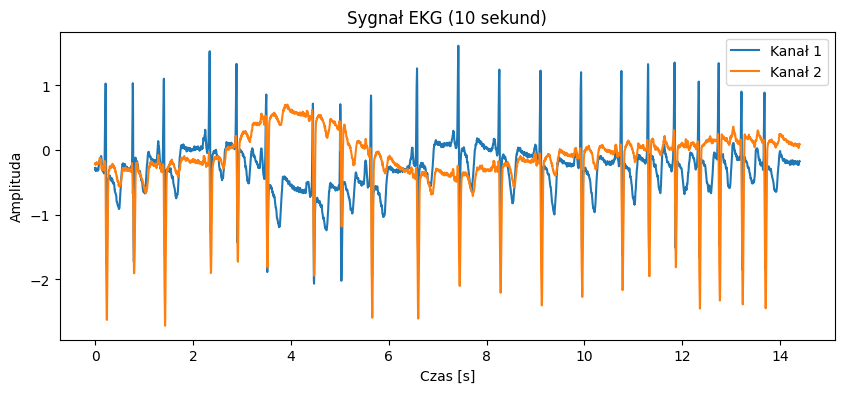


Adnotacje:
Czas: 0.12s, Typ arytmii: (N
Czas: 410.34s, Typ arytmii: (AFIB
Czas: 478.42s, Typ arytmii: (N
Czas: 487.09s, Typ arytmii: (AFIB
Czas: 488.78s, Typ arytmii: (N
Czas: 533.39s, Typ arytmii: (AFIB
Czas: 667.43s, Typ arytmii: (N
Czas: 4384.98s, Typ arytmii: (AFIB
Czas: 4392.22s, Typ arytmii: (N
Czas: 4541.18s, Typ arytmii: (AFIB
Czas: 4558.38s, Typ arytmii: (N
Czas: 5689.74s, Typ arytmii: (AFIB
Czas: 5694.19s, Typ arytmii: (N
Czas: 5837.11s, Typ arytmii: (AFIB


In [96]:
import matplotlib.pyplot as plt

# Wczytaj rekord z MIT-BIH Arrhythmia Database (np. rekord 100)
record = wfdb.rdrecord(data_dir + '/04015')  # Zastąp ścieżką do lokalnego pliku

# Wczytaj adnotacje
annotation = wfdb.rdann(data_dir + '/04015', 'atr')  # Adnotacje dla rekordu 100

# Wyświetl podstawowe informacje o sygnale
print("Informacje o sygnale:")
print(f"Częstotliwość próbkowania: {record.fs} Hz")
print(f"Czas trwania sygnału: {record.sig_len / record.fs} s")
print(f"Liczba kanałów: {record.n_sig}")

# Wykres sygnału EKG (pierwsze 10 sekund)
time = [i / record.fs for i in range(record.sig_len)]  # Oś czasu
plt.figure(figsize=(10, 4))
plt.plot(time[:3600], record.p_signal[:3600, 0], label="Kanał 1")  # Pierwszy kanał
plt.plot(time[:3600], record.p_signal[:3600, 1], label="Kanał 2")  # Drugi kanał
plt.xlabel('Czas [s]')
plt.ylabel('Amplituda')
plt.title('Sygnał EKG (10 sekund)')
plt.legend()
plt.show()

# Wyświetl adnotacje (typ arytmii i pozycje w czasie)
print("\nAdnotacje:")
for idx, sample in enumerate(annotation.sample[:14]):  # Przykładowe pierwsze 10 adnotacji
    time_sec = sample / record.fs
    label = annotation.aux_note[idx]
    print(f"Czas: {time_sec:.2f}s, Typ arytmii: {label}")


Wyświetl otoczenie migotania

start:102584    end: 119604


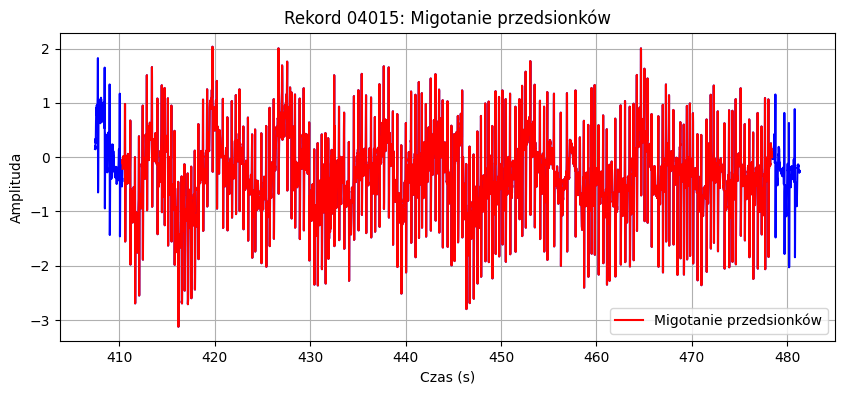

start:121773    end: 122194


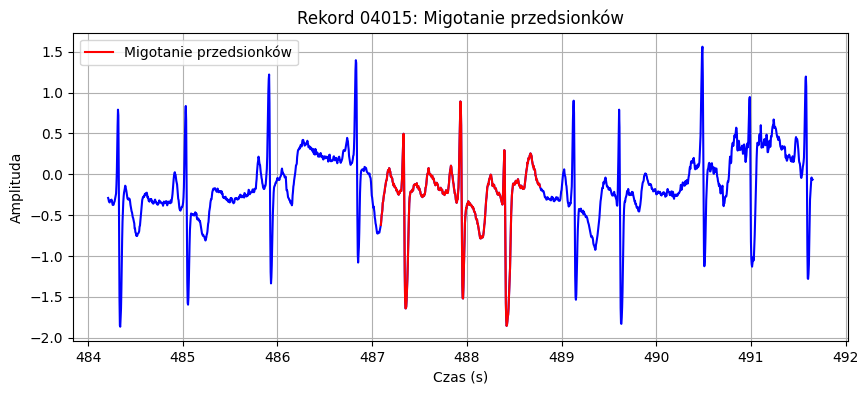

start:133348    end: 166857


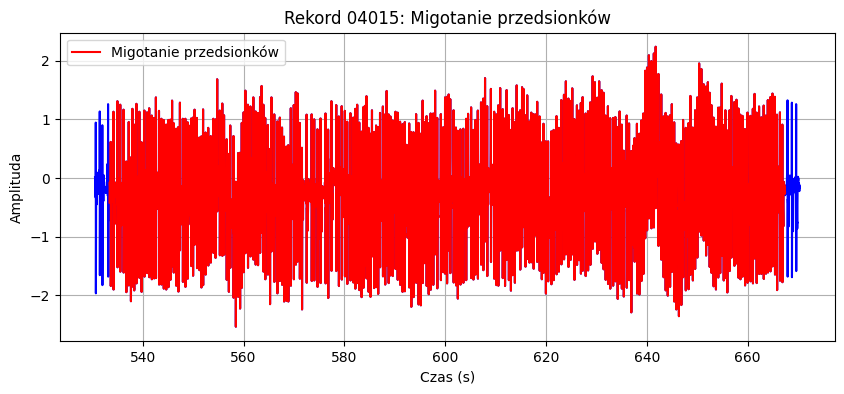

start:1096245    end: 1098054


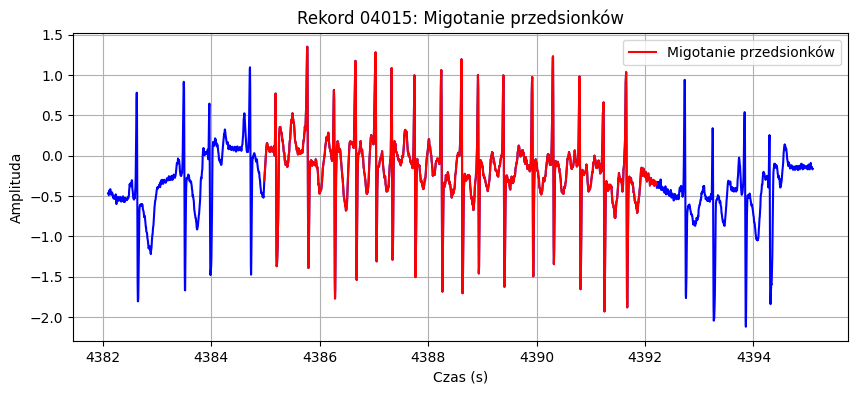

start:1135296    end: 1139595


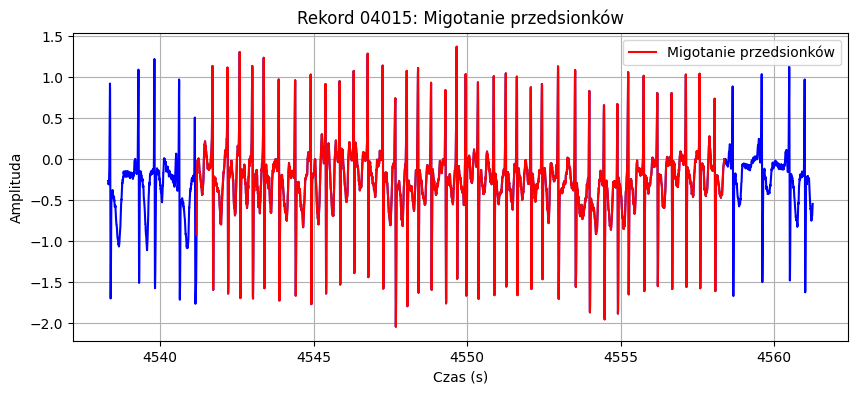

start:1422436    end: 1423548


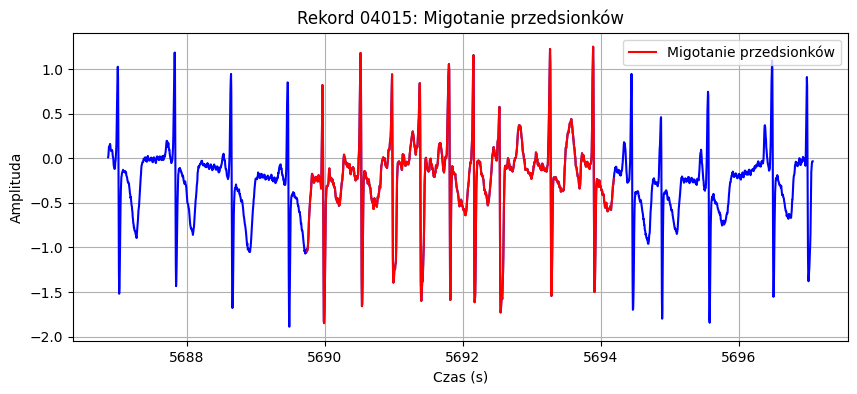

start:1459277    end: 1460416


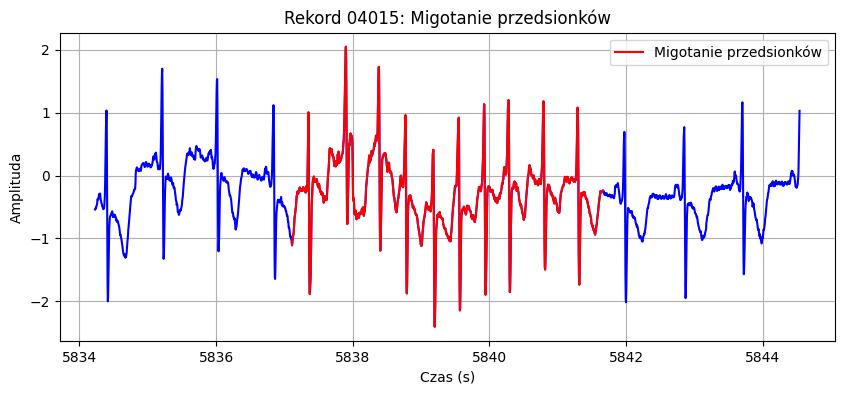

In [112]:
sampling_rate = 250  # częstość próbkowania w Hz
context_window = 720  # liczba próbek do pokazania przed i po zaznaczonym obszarze

# Przechodzenie przez pliki w katalogu
for record_file in os.listdir(data_dir):
    if record_file.endswith('.dat'):  # Upewnij się, że to plik .dat
        # Ustal nazwę rekordu bez rozszerzenia
        record_name = record_file[:-4]

        # Wczytaj rekord i adnotacje
        record = wfdb.rdrecord(os.path.join(data_dir, record_name))
        annotation = wfdb.rdann(os.path.join(data_dir, record_name), 'atr')

        # Znajdź indeksy adnotacji
        bracket_start_indices = [i for i, sym in enumerate(annotation.aux_note) if sym == '(AFIB']

        for start_idx in bracket_start_indices:
            end_idx = start_idx + 1

            # Indeksy próbek sygnału
            start_sample = annotation.sample[start_idx]
            end_sample = annotation.sample[end_idx]

            # Ustal indeksy próbek z dodatkowymi marginesami przed i po obszarze zaznaczonym
            plot_start = max(0, start_sample - context_window)
            plot_end = min(len(record.p_signal), end_sample + context_window)
            print(f"start:{start_sample}    end: {end_sample}")
            # Wyciągnij fragment sygnału EKG do wyświetlenia
            segment = record.p_signal[plot_start:plot_end, 0]

            # Oblicz czas w sekundach dla osi X
            time = np.arange(plot_start, plot_end) / sampling_rate

            # Tworzenie wykresu dla danego przedziału
            plt.figure(figsize=(10, 4))

            # Rysowanie obszaru poza przedziałem na niebiesko
            plt.plot(time, segment, color='blue')

            # Zaznaczenie obszaru na czerwono
            plt.plot(
                np.arange(start_sample, end_sample) / sampling_rate,
                record.p_signal[start_sample:end_sample, 0],
                color='red', label='Migotanie przedsionków'
            )

            # Konfiguracja wykresu
            plt.xlabel('Czas (s)')
            plt.ylabel('Amplituda')
            plt.title(f'Rekord {record_name}: Migotanie przedsionków')
            plt.grid()
            plt.legend()
            plt.show()

        # Jeśli chcesz zatrzymać przeszukiwanie po znalezieniu pierwszego rekordu, odkomentuj poniższą linię:
        break


Generacja wektora Y

In [ ]:
sampling_rate = 250  # częstość próbkowania w Hz

# Przechodzenie przez pliki w katalogu
for record_file in os.listdir(data_dir):
    if record_file.endswith('.dat'):  # Upewnij się, że to plik .dat
        # Ustal nazwę rekordu bez rozszerzenia
        record_name = record_file[:-4]

        # Wczytaj rekord i adnotacje
        record = wfdb.rdrecord(os.path.join(data_dir, record_name))
        annotation = wfdb.rdann(os.path.join(data_dir, record_name), 'atr')

        # Inicjalizuj wektor oznaczeń o długości sygnału z wartościami 0
        afib_vector = np.zeros(record.sig_len, dtype=int)

        # Znajdź indeksy adnotacji
        bracket_start_indices = [i for i, sym in enumerate(annotation.aux_note) if sym == '(AFIB']

        for start_idx in bracket_start_indices:
            end_idx = start_idx + 1

            # Indeksy próbek sygnału
            start_sample = annotation.sample[start_idx]
            if end_idx < len(annotation.sample):
                end_sample = annotation.sample[end_idx]
            else:
                end_sample = annotation.sample[-1]
            # Ustaw wartość 1 w wektorze dla zakresu migotania przedsionków
            afib_vector[start_sample:end_sample] = 1

        output_path = os.path.join("../data/processed/afdb", f"{record_name}_afib.npy")
        np.save(output_path, afib_vector)
        # Wczytaj plik .npy
        afib_vector33 = np.load(output_path)

        # Jeśli chcesz zatrzymać przeszukiwanie po znalezieniu pierwszego rekordu, odkomentuj poniższą linię:
        break


Sprawdzenie wygenerowanych wektorów

In [113]:
import numpy as np

# Ścieżka do pliku .npy z wektorem migotania przedsionków
file_path = '../data/processed/afdb/04015_afib.npy'  # Zmień na odpowiednią nazwę pliku

# Wczytaj plik .npy
afib_vector = np.load(file_path)

# Znajdź przedziały, gdzie wartość wynosi 1 (migotanie przedsionków)
afib_intervals = []
in_interval = False
start_index = None

for i, value in enumerate(afib_vector):
    if value == 1 and not in_interval:
        # Rozpoczęcie nowego przedziału
        start_index = i
        in_interval = True
    elif value == 0 and in_interval:
        # Koniec przedziału
        afib_intervals.append((start_index, i - 1))
        in_interval = False

# Dodaj ostatni przedział, jeśli wektor kończy się jedynką
if in_interval:
    afib_intervals.append((start_index, len(afib_vector) - 1))

# Wyświetl wyniki
print("Indeksy przedziałów migotania przedsionków:")
for interval in afib_intervals:
    print(f"Start: {interval[0]}, Koniec: {interval[1]}")


Indeksy przedziałów migotania przedsionków:
Start: 102584, Koniec: 119603
Start: 121773, Koniec: 122193
Start: 133348, Koniec: 166856
Start: 1096245, Koniec: 1098053
Start: 1135296, Koniec: 1139594
Start: 1422436, Koniec: 1423547
Start: 1459277, Koniec: 1460415
